In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [26]:
# Using the GPU if it exists
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [27]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.CIFAR100(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR100(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000)

In [28]:
model_normal = nn.Sequential(
    nn.Flatten(),
    nn.Linear(32*32*3, 512),  #From 32x32 RGB 
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 100)       
)

In [29]:
# Training loop
def train(model, loader, optimizer, loss_fn, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = loss_fn(logits, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# Testing loop
def test(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    print(f"Accuracy: {100 * correct / total:.2f}%")


In [30]:
print("\nCifar-100 Model")
cifar_model = model_normal.to(device)
optimizer_seq = optim.Adam(cifar_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

train(cifar_model, train_loader, optimizer_seq, loss_fn)
test(cifar_model, test_loader)


Cifar-100 Model
Epoch 1, Loss: 2915.7846
Epoch 2, Loss: 2610.4922
Epoch 3, Loss: 2464.9071
Epoch 4, Loss: 2345.3432
Epoch 5, Loss: 2239.5449
Accuracy: 23.09%


In [31]:
class CIFARNet(nn.Module):
    def __init__(self):
        super(CIFARNet, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 100)
        
    def forward(self, x):
        x = x.view(-1, 32*32*3)     # Flatten the image
        x = F.relu(self.fc1(x))     # First layer + ReLU
        x = F.relu(self.fc2(x))     # Second layer + ReLU
        x = self.fc3(x)             # Final layer (logits)
        return x

In [32]:
print("\nUsing nn.functional")
model = CIFARNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

train(model, train_loader, optimizer, loss_fn)
test(model, test_loader)


Using nn.functional
Epoch 1, Loss: 2923.1245
Epoch 2, Loss: 2623.7310
Epoch 3, Loss: 2474.2449
Epoch 4, Loss: 2358.3736
Epoch 5, Loss: 2250.8000
Accuracy: 23.07%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6313726..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..0.81960785].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92941177..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.9607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.85882354..0.92941177].


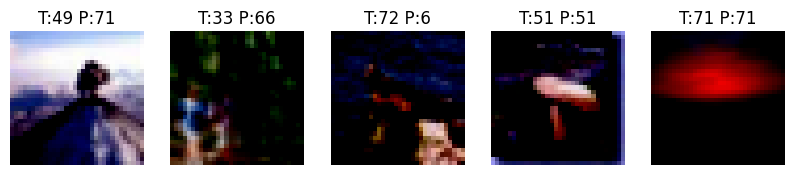

In [33]:
def visualize(model, loader, n=5):
    model.eval()
    x, y = next(iter(loader))
    x, y = x.to(device), y.to(device)
    preds = model(x).argmax(dim=1)

    plt.figure(figsize=(10, 2))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(x[i].cpu().permute(1, 2, 0))  
        plt.title(f"T:{y[i].item()} P:{preds[i].item()}")
        plt.axis('off')
    plt.show()

visualize(model, test_loader) # Uncomment this later
#visualize(sequential_model, test_loader)